In [1]:
import tensorflow as tf
import numpy as np
from CNN import get_cnn
import os
import time
import datetime
import pickle
import csv
import gensim

K = 400 # word2vec embedding dimension
L = 50 # 50 words limit for each sentence
NUM_CLASSES = 2

_x = tf.placeholder(tf.float32, [None, L, K], name='input_x')
_y = tf.placeholder(tf.float32, [None, NUM_CLASSES], name='input_y')

# Load the CNN architecture
scores, predictions, loss, accuracy, deep_feature = get_cnn(_x, _y, 0, get_deep_feature=True)

print('CNN architecture is loaded!')

W0819 15:28:12.411718  8100 deprecation_wrapper.py:119] From C:\Users\yanpe\Desktop\NLP_paper\CNN_NLP\CNN.py:24: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0819 15:28:12.425681  8100 deprecation_wrapper.py:119] From C:\Users\yanpe\Desktop\NLP_paper\CNN_NLP\CNN.py:31: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0819 15:28:12.469564  8100 deprecation_wrapper.py:119] From C:\Users\yanpe\Desktop\NLP_paper\CNN_NLP\CNN.py:56: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0819 15:28:13.434988  8100 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an i

CNN architecture is loaded!


## Load word2vec model

In [2]:
MODEL_PATH = '../word2vec_twitter_model.bin'
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(MODEL_PATH, binary=True, limit=3000000)
#w2v_model = gensim.models.KeyedVectors.load_word2vec_format(MODEL_PATH, binary=True, limit=300000)

## Demo

In [3]:
#'''
input_texts = [
    'cocaine snorting day',
    'vape lot bud err day',
    'gonna injest a tabs get real',
    'inhale nitrous stay up enjoy',
    'shoot up that real smack enjoy',
    'like LSD seeing the colour',
    'heroin blaze it all time',
    'injesting toking doping xanax',
        'injecting toking doping xanax',
    'chewing shrooms kind day',
    'make mary jane enjoy pot smoke'
    'i enjoy smoking weed',
    'the government should legalize crack and meth',
    'snorting cocaine is a good time',
    'smoke weed everyday',
    'there is a man by the arcade selling sweetest dope',
    'i should switch to crack and become the largest of the crack heads',
    'smoking a blunt and keeping it real',
    '420 blaze it with some sweet bud',
    'the world would be better if we all smoked weed and did LSD',
    'thinking about moving up to something more powerful perhaps crack or coke',
    '=========',
    'i think all drugs should be illegal',
    'the chimney is smoking and I mowed the grass',
    'the opioid crisis has gotten out of control',
    'my mom says cocaine and pills lead to failure',
    'i have never done drugs especially not weed',
    'special k is delicious',
    'i feel like a complete dope',
    'my bud and I are going to board on the sweet powder',
    'the government should do something about all these drugs',
    'people should in fact not smoke weed everyday'
]
#'''

x_ = []
for tweet in input_texts:
    tmp = []
    for word in tweet.split(' '):
        try:
            tmp.append(w2v_model[word])
        except:
            print('Och, the word \"'+word+'\" cannot be found in the w2v model!')
            ''' OOV word '''
            tmp.append(np.random.uniform(-0.5,0.5,K)) # random vector range:(-0.5, 0.5)
        if len(tmp) == L:
            break # 50 words limit!!
    while len(tmp) < L:
        ''' pad with zero vectors if less than 50 words '''
        tmp.append(np.zeros(K)) 
    x_.append(np.array(tmp))
x_ = np.array(x_)

print('\ninput shape: ',x_.shape)

with tf.Session() as sess:
    # Load parameters
    saver = tf.train.Saver()
    saver.restore(sess, 'saved_model/model.ckpt')

    pred = sess.run([predictions], feed_dict={_x: x_})

    pred = np.array(pred[0])
    
    ''' Display result '''
    print('\nRESULTS (+: positive; -: negative):')
    for i in range(len(input_texts)):
        if pred[i] == 1:
            print('+: ',input_texts[i])
        else:
            print('-: ',input_texts[i])

Och, the word "smokei" cannot be found in the w2v model!
Och, the word "420" cannot be found in the w2v model!
Och, the word "=========" cannot be found in the w2v model!

input shape:  (31, 50, 400)


W0819 15:29:52.888441  8100 deprecation.py:323] From c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.



RESULTS (+: positive; -: negative):
+:  cocaine snorting day
+:  vape lot bud err day
+:  gonna injest a tabs get real
+:  inhale nitrous stay up enjoy
-:  shoot up that real smack enjoy
+:  like LSD seeing the colour
+:  heroin blaze it all time
+:  injesting toking doping xanax
+:  injecting toking doping xanax
+:  chewing shrooms kind day
+:  make mary jane enjoy pot smokei enjoy smoking weed
+:  the government should legalize crack and meth
+:  snorting cocaine is a good time
+:  smoke weed everyday
-:  there is a man by the arcade selling sweetest dope
-:  i should switch to crack and become the largest of the crack heads
-:  smoking a blunt and keeping it real
+:  420 blaze it with some sweet bud
+:  the world would be better if we all smoked weed and did LSD
-:  thinking about moving up to something more powerful perhaps crack or coke
+:  =========
-:  i think all drugs should be illegal
-:  the chimney is smoking and I mowed the grass
-:  the opioid crisis has gotten out of co

## ROC Curve Testing

In [9]:
with tf.Session() as sess:
    # Load parameters
    saver = tf.train.Saver()
    #saver.restore(sess, 'saved_model/model.ckpt')
    saver.restore(sess, 'saved_model-best/model.ckpt')

    scor = sess.run([scores], feed_dict={_x: x_})


W0819 15:16:13.615740 10132 deprecation.py:323] From c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


NameError: name 'x_' is not defined

In [6]:
scor

[array([[-2.2844472 ,  0.45230508],
        [ 0.3246349 , -0.4336147 ],
        [ 0.5988334 , -1.1328299 ],
        [-1.4545765 ,  0.09920391],
        [ 1.5917889 , -1.4656153 ],
        [ 2.2871933 , -2.539256  ],
        [-0.8220365 , -1.5007877 ],
        [-1.4454064 ,  0.7006907 ],
        [-2.2311022 ,  1.469138  ],
        [-1.2664328 ,  0.61699057],
        [-0.8129853 ,  0.30081043],
        [ 0.57452106, -1.9074421 ],
        [-0.5743528 , -0.2270588 ],
        [-4.715733  ,  3.3147125 ],
        [ 3.0354025 , -4.5918922 ],
        [ 3.4133363 , -5.0883327 ],
        [-0.07833821, -0.06570707],
        [ 1.1480099 , -1.2819974 ],
        [-0.45785207, -1.0113585 ],
        [ 2.02484   , -3.5441687 ],
        [-0.39897382,  0.24424061],
        [ 1.7863067 , -2.7242336 ],
        [ 0.19401729, -2.7403276 ],
        [ 5.477749  , -3.5069795 ],
        [ 1.0294707 , -2.238199  ],
        [ 0.4842878 , -2.35853   ],
        [ 2.2836828 , -3.001885  ],
        [ 1.7965034 , -2.756

In [7]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [8]:
positive_scores = np.zeros(len(scor[0]))

In [16]:
for i in range(len(scor[0])):
    positive_scores[i] = sigmoid(scor[0][i][1] - scor[0][i][0])

In [17]:
positive_scores

array([9.39160796e-01, 3.19026409e-01, 1.50374956e-01, 8.25459070e-01,
       4.48988960e-02, 7.95120038e-03, 3.36540075e-01, 8.95303509e-01,
       9.75878632e-01, 8.68003845e-01, 7.52836084e-01, 7.71323413e-02,
       5.85961225e-01, 9.99674703e-01, 4.86739556e-04, 2.03087827e-04,
       5.03157749e-01, 8.09129124e-02, 3.65051268e-01, 3.79976597e-03,
       6.55479727e-01, 1.08729961e-02, 5.04816569e-02, 1.25293304e-04,
       3.66971167e-02, 5.50537634e-02, 5.03863975e-03, 1.04306943e-02,
       6.10929948e-04, 6.13838606e-03, 5.30161477e-01])

In [18]:
from sklearn.metrics import roc_curve, auc

In [19]:
ground_truth = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0]

In [20]:
fpr, tpr, thresholds = roc_curve(ground_truth, positive_scores)
roc_auc = auc(fpr, tpr)


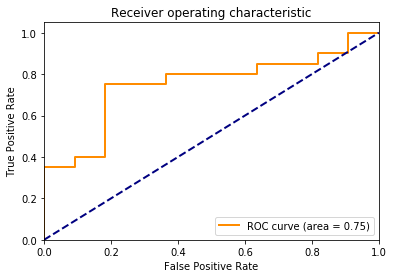

In [21]:
import matplotlib.pyplot as plt
lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [5]:
#'''
input_texts = [
    'i think all drugs should be illegal',
]
#'''

x_ = []
for tweet in input_texts:
    tmp = []
    for word in tweet.split(' '):
        try:
            tmp.append(w2v_model[word])
        except:
            print('Och, the word \"'+word+'\" cannot be found in the w2v model!')
            ''' OOV word '''
            tmp.append(np.random.uniform(-0.5,0.5,K)) # random vector range:(-0.5, 0.5)
        if len(tmp) == L:
            break # 50 words limit!!
    while len(tmp) < L:
        ''' pad with zero vectors if less than 50 words '''
        tmp.append(np.zeros(K)) 
    x_.append(np.array(tmp))
x_ = np.array(x_)

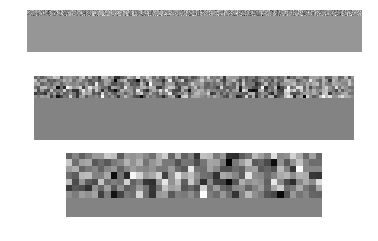

In [23]:
import matplotlib.pyplot as plt
from PIL import Image

sample = x_[0].reshape(L,K)

plt.subplot(3,1,1)
plt.imshow(sample, cmap=plt.get_cmap('gray'))
plt.axis('off')

plt.subplot(3,1,2)
plt.imshow(sample[:20,:100], cmap=plt.get_cmap('gray'))
plt.axis('off')

plt.subplot(3,1,3)
plt.imshow(sample[:10,:40], cmap=plt.get_cmap('gray'))
plt.axis('off')

#plt.set_cmap('hot')

plt.savefig("Figures/"+"w2v_2.png",dpi=1500)

In [4]:
''' load training dataset '''
TEST_DATA_PATH = 'dataset/train_set_with_synthetic.csv' 

TWEETS_LIST = []
LABEL_LIST = []
with open(TEST_DATA_PATH, newline='') as csvfile:
    csvreader = list(csv.reader(csvfile, delimiter=','))
    for row in csvreader[1:]:
        TWEETS_LIST.append(row[2]) # the third row is the original text
        #TWEETS_LIST.append(row[1]) # the second row is the modified text

        if row[3] == '0':
            ''' Negative '''
            LABEL_LIST.append([1,0])
        else:
            ''' Positive '''
            LABEL_LIST.append([0,1])
print('Training dataset loaded')
print('Number of tweets in training dataset: ',len(TWEETS_LIST))

''' preprocess data '''
x_train = []
for tweet in TWEETS_LIST:
    tmp = []
    for word in tweet.split(' '):
        try:
            tmp.append(w2v_model[word]) # find word from W2V
        except:
            ''' OOV word '''
            tmp.append(np.random.uniform(-0.5,0.5,K)) # random vector range:(-0.5, 0.5)
        if len(tmp) == L:
            break # 50 words limit!!
    while len(tmp) < L:
        ''' pad with zero vectors if less than 50 words '''
        tmp.append(np.zeros(K)) 
    x_train.append(np.array(tmp))
x_train = np.array(x_train)
y_train = np.array(LABEL_LIST)

''' Random shuffle the data '''
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(x_train)))
x_train = x_train[shuffle_indices]
y_train = y_train[shuffle_indices]

print('Data Preprocessed!')

Training dataset loaded
Number of tweets in training dataset:  12141
Data Preprocessed!


In [5]:
''' load testing dataset '''
TEST_DATA_PATH = 'dataset/test_set-actual-pure.csv' # the path of testing data

TWEETS_LIST = []
LABEL_LIST = []
with open(TEST_DATA_PATH, newline='') as csvfile:
    csvreader = list(csv.reader(csvfile, delimiter=','))
    for row in csvreader[1:]:
        TWEETS_LIST.append(row[2]) # the third row is the original text
        #TWEETS_LIST.append(row[1]) # the second row is the modified text

        if row[3] == '0':
            ''' Negative '''
            LABEL_LIST.append([1,0])
        else:
            ''' Positive '''
            LABEL_LIST.append([0,1])
print('Training dataset loaded')
print('Number of tweets in training dataset: ',len(TWEETS_LIST))

''' preprocess data '''
x_test = []
for tweet in TWEETS_LIST:
    tmp = []
    for word in tweet.split(' '):
        try:
            tmp.append(w2v_model[word]) # find word from W2V
        except:
            ''' OOV word '''
            tmp.append(np.random.uniform(-0.5,0.5,K)) # random vector range:(-0.5, 0.5)
        if len(tmp) == L:
            break # 50 words limit!!
    while len(tmp) < L:
        ''' pad with zero vectors if less than 50 words '''
        tmp.append(np.zeros(K)) 
    x_test.append(np.array(tmp))
x_test = np.array(x_test)
y_test = np.array(LABEL_LIST)

''' Random shuffle the data '''
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(x_test)))
x_test = x_test[shuffle_indices]
y_test = y_test[shuffle_indices]

print('Data Preprocessed!')

Training dataset loaded
Number of tweets in training dataset:  1040
Data Preprocessed!


In [6]:
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, 'saved_model-best/model.ckpt')
    
"""Extract deep features"""
x_train_df = sess.run(deep_feature, feed_dict={_x: x_train})
x_test_df = sess.run(deep_feature, feed_dict={_x: x_test})

In [7]:
np.save("x_train_df", x_train_df)
np.save("y_train_df", y_train)
np.save("x_test_df", x_test_df)
np.save("y_test_df", y_test)

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
plt.imshow(x_train_df[:100,:])

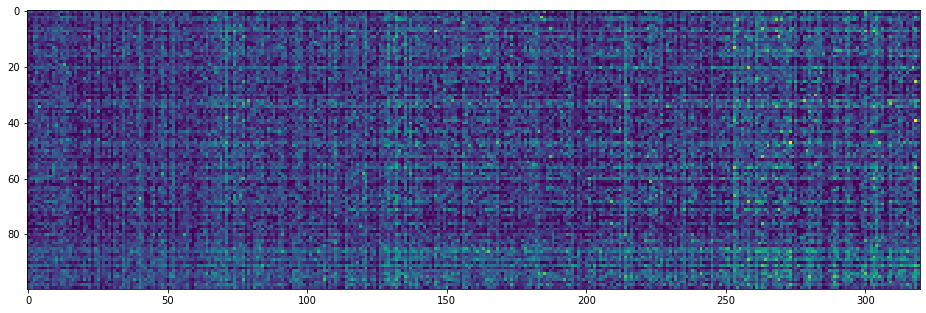

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
plt.imshow(x_test_df[:100,:])